# Import

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [23]:
import matplotlib
matplotlib.font_manager._rebuild()

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression

from lightgbm import LGBMRegressor

#import lightgbm as lgb

from lightgbm import plot_importance 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc

# Data Import
1. iszero
2. nozero
3. nf (new feature)
---
- input featrue = 27
- 7일간 data를 하나의 instance화 한다면 -> input matrix 7 x 26 -> ouput matrix 7 x 1 (가격만 출력)
- 2148 row x 26 columns
- 다변량 시계열(multiivariate time series) 예측 system
- In our cousre DA, design for 단변량 시계열(univariate time series) prediction
- 2014.01.01~2020.12.31 data
- 건고추는 2014.01.22부터, 나머지는 대부분 2014.01.02부터

In [8]:
path = "./Dataset/"
price_tag = ['건고추가격', '대파가격', '마늘가격', '무가격', '배추가격']
crops_en = ['peppers', 'green_onion', 'garlic', 'radish', 'cabbage']

# is zero
isZero = pd.read_csv(path+"da_data.csv")

# no zero 
noZero = pd.read_csv(path+"da_data_nozero.csv")

# new features 
nf_peppers = pd.read_csv(path+"last건고추.csv")
nf_green_onion = pd.read_csv(path+"last대파.csv")
nf_garlic = pd.read_csv(path+"last마늘.csv")
nf_radish = pd.read_csv(path+"last무.csv")
nf_cabbage = pd.read_csv(path+"last배추.csv")

original_data_list = [nf_peppers, nf_green_onion, nf_garlic, nf_radish, nf_cabbage]

In [9]:
X_column_pepper = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '건고추거래량', '건고추생산량', '건고추저장이월량', '건고추수입량', '건고추수입금액',
       '건고추재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_pepper = ['건고추가격']

X_column_green_onion = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '대파거래량', '대파생산량', '대파저장이월량', '대파수입량', '대파수입금액',
       '대파재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_green_onion = ['대파가격']

X_column_garlic = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '마늘거래량', '마늘생산량', '마늘저장이월량', '마늘수입량', '마늘수입금액',
       '마늘재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_garlic = ['마늘가격']

X_column_radish = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '무거래량', '무생산량', '무저장이월량', '무수입량', '무수입금액',
       '무재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_radish = ['무가격']

X_column_cabbage = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '배추거래량', '배추생산량', '배추저장이월량', '배추수입량', '배추수입금액',
       '배추재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_cabbage = ['배추가격']

X_column_list = [X_column_pepper, X_column_green_onion, X_column_garlic, X_column_radish, X_column_cabbage]
y_column_list = [y_column_pepper, y_column_green_onion, y_column_garlic, y_column_radish, y_column_cabbage] # oh...is same thing with p-tag...

# 함수화

In [10]:
def outliers_iqr(data, name) :
  print('원본 데이터 수 : ', len(data))

  Q1, Q3 = np.percentile(data[name], [25, 75])
  IQR = Q3 - Q1
  lower_bound = Q1 - (IQR * 1.5)
  upper_bound = Q3 + (IQR * 1.5)
  outlier_index = data[name][ (data[name] < lower_bound) | (data[name] > upper_bound) ].index.tolist()

  # 가격열 이상치 1일전/후 데이터의 평균값으로 대체
  num1list = [1] * len(outlier_index)
  outlier_pre = [outlier_index[i] - num1list[i] for i in range(len(outlier_index))]
  outlier_post = [outlier_index[i] + num1list[i] for i in range(len(outlier_index))]
  print(outlier_pre, '\n', outlier_post)

  outlier_sum = [data.loc[outlier_pre, name].tolist()[i] + data.loc[outlier_post, name].tolist()[i] for i in range(len(outlier_index))]
  num2list = [2] * len(outlier_index)
  outlier_result = [outlier_sum[i] / num2list[i] for i in range(len(outlier_index))]
  # print(data.loc[outlier_pre, name].tolist())
  # print(data.loc[outlier_post, name].tolist())
  # print(outlier_result)
  data.loc[outlier_index, name] = outlier_result
  print(data)
  return data

def pre_processing(data) :
    scaler = MinMaxScaler()
    scale_cols = data.iloc[:,2:].columns
    
    data.sort_index(ascending=False).reset_index(drop=True)
    
    scaled = scaler.fit_transform(data[scale_cols])
    scaled = pd.DataFrame(scaled)
    scaled.columns = scale_cols
    
    return scaled


def get_data_split(data, X_column, y_column) :
    train_X, test_X, train_y, test_y = train_test_split(
    data[X_column], 
    data[y_column],
    test_size=0.2,
    shuffle=True,   # random split 
    random_state=42) # seed 고정, same sampling 
    print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)
    
    return train_X, test_X, train_y, test_y


def get_model_cv_prediction(model, X_data, y_label) :
    neg_mse_scores = cross_val_score(model, X_data, y_label, scoring="neg_mean_squared_error", cv=5)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('####', model.__class__.__name__, '####')
    print('5 교차 검증의 평균 RMSE : {0:.3f}'.format(avg_rmse))


def gridsearchCV (model, parameters, X_train, y_train) :
    grid = GridSearchCV(model, param_grid = parameters, scoring='accuracy', cv=2) # cv is fold num
    grid.fit(X_train, y_train)
    
    print('GridSearchCV 최적 하이퍼 파라미터 :', grid.best_params_)
    print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid.best_score_))
    print('GridSearchCV 최적 하이퍼 파라미터로 학습된 Esimator 반환')
    
    return grid.best_estimator_


def feature_importance(model_xgb) : 
    %matplotlib inline
    plt.rcParams['axes.unicode_minus'] = False
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = fm.FontProperties(fname=font_path).get_name()
    rc('font', family=font)

    fig, ax = plt.subplots(figsize=(10,12))
    plot_importance(model_xgb, ax=ax)


def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

# Preproecssing 

input_data_list -> 0:건고추, 1:대파, 2:마늘, 3:무, 4:배추

In [11]:
input_data_list = []
for data, tag in zip(original_data_list, price_tag) : 
    out_lier = outliers_iqr(data, tag)
    processed = pre_processing(out_lier)
    input_data_list.append(processed)

원본 데이터 수 :  2211
[1038, 1039, 1040, 1048, 1053, 1061, 1062, 1063, 1065, 1066, 1067, 1069, 1070, 1071, 1075, 1078, 1081, 1082, 1083, 1084, 1085, 1086, 1088, 1089, 1093, 1144, 1337, 1338, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1354, 1355, 1360, 1361, 1362, 1367, 1368, 1394, 1486, 1487, 1488, 1518, 1543, 1573, 1574, 1604, 1663, 1664, 1665, 1696, 1758, 1816, 1842, 1847, 1848, 1875, 1876, 1903, 1905, 1906, 1922, 1924, 1925, 1933, 1934, 1947, 1948, 1954, 2066, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2085, 2087, 2088, 2089, 2090, 2091, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2101, 2102, 2103, 2108, 2112, 2114, 2118, 2122, 2128, 2129, 2130, 2131, 2136, 2137, 2138, 2140, 2141, 2142, 2143, 2144, 2148, 2149, 2151, 2153, 2154, 2155, 2156, 2157, 2160, 2163, 2164, 2185, 2204] 
 [1040, 1041, 1042, 1050, 1055, 1063, 1064, 1065, 1067, 1068, 1069, 1071, 1072, 1073, 1077, 1080, 1083, 1084, 1085, 1086, 1087, 1088, 1090, 1091, 1

      Unnamed: 0          날짜  평균강수량  최대강수량  평균기온  최고기온  최저기온  평균습도  최저습도  \
0              0  2014-01-02    0.0    0.0   2.6   9.1  -2.2    49    10   
1              1  2014-01-03    0.0    0.0   2.6  10.1  -3.2    54    12   
2              2  2014-01-04    1.2   31.0   1.5   6.9  -2.8    63    12   
3              3  2014-01-05    0.1   30.2   0.7   6.6  -3.7    62     9   
4              4  2014-01-06    0.0   11.0   0.2   7.6  -5.1    59    12   
...          ...         ...    ...    ...   ...   ...   ...   ...   ...   
2534        2534  2020-12-27    2.1   53.2   3.2   8.1  -1.0    77    18   
2535        2535  2020-12-28    0.1    1.4   4.2  11.9  -0.4    80    22   
2536        2536  2020-12-29    1.8    6.9   2.1   8.6  -2.3    81    31   
2537        2537  2020-12-30    1.1   33.4  -6.8  -1.1  -9.7    56    17   
2538        2538  2020-12-31    0.2    5.2  -6.4  -1.4 -11.9    59    18   

      평균풍속  ...    보통휘발유   자동차용경유  소비자물가지수  농축수산물  공업제품   집세  공공서비스  개인서비스  \
0      1.

In [12]:
input_data_list[0]

,평균강수량,최대강수량,평균기온,최고기온,최저기온,평균습도,최저습도,평균풍속,최대풍속,건고추가격,...,보통휘발유,자동차용경유,소비자물가지수,농축수산물,공업제품,집세,공공서비스,개인서비스,근원물가,생활물가
0,0.000000,0.000000,0.189189,0.209524,0.162963,0.446154,0.161765,0.272727,0.239726,0.047478,...,1.000000,1.000000,0.517241,0.119816,0.840909,0.896552,0.839080,0.15,0.64,0.340909
1,0.000000,0.000260,0.230958,0.297619,0.175309,0.476923,0.176471,0.113636,0.127854,0.095260,...,0.999419,0.999690,0.517241,0.119816,0.840909,0.896552,0.839080,0.15,0.64,0.340909
2,0.000000,0.000000,0.353808,0.383333,0.274074,0.538462,0.338235,0.250000,0.139269,0.047478,...,0.998604,0.998775,0.517241,0.119816,0.840909,0.896552,0.839080,0.15,0.64,0.340909
3,0.001963,0.014052,0.302211,0.271429,0.320988,0.492308,0.382353,0.340909,0.136986,0.048462,...,0.992123,0.991131,0.482759,0.129032,0.840909,0.931034,0.839080,0.00,0.64,0.295455
4,0.000000,0.002602,0.297297,0.340476,0.259259,0.476923,0.220588,0.181818,0.146119,0.097227,...,0.991998,0.990728,0.482759,0.129032,0.840909,0.931034,0.839080,0.00,0.64,0.295455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,0.020608,0.138434,0.334152,0.321429,0.335802,0.707692,0.264706,0.045455,0.159817,0.329237,...,0.249886,0.230711,0.310345,0.824885,0.250000,0.310345,0.528736,0.20,0.32,0.181818
2207,0.000981,0.003643,0.358722,0.411905,0.350617,0.753846,0.323529,0.022727,0.038813,0.263945,...,0.254342,0.235533,0.310345,0.824885,0.250000,0.310345,0.528736,0.20,0.32,0.181818
2208,0.017664,0.017955,0.307125,0.333333,0.303704,0.769231,0.455882,0.227273,0.337900,0.314764,...,0.260838,0.241658,0.310345,0.824885,0.250000,0.310345,0.528736,0.20,0.32,0.181818
2209,0.010795,0.086911,0.088452,0.102381,0.120988,0.384615,0.250000,0.727273,0.509132,0.254921,...,0.266000,0.246992,0.310345,0.824885,0.250000,0.310345,0.528736,0.20,0.32,0.181818


# Modeling 
1. model_xgb_1 : 파이썬 래퍼 클래스
2. model_xgb_2 : 사이킷런 래퍼 클래스 -> 사이킷런 기반 Estimator를 상속받아 작성됨  


In [13]:
input_data = pre_processing(input_data_list[0])
 
train_X, test_X, train_y, test_y = get_data_split(input_data_list[0], X_column_list[0], y_column_list[0])

(1768, 26) (443, 26) (1768, 1) (443, 1)


In [15]:
params = { 
    'max_depth':3,
    'eta':0.1,
    'objective':'reg:linear',
    'eval_metric':'logloss',
    'early_stoppings':100
}
evals = [(test_X, test_y)]

model_lgbm = LGBMRegressor(n_estimators=1000, learning_rate=0.001)
model_lgbm.fit(train_X, train_y, early_stopping_rounds=100, eval_metric="logloss",
               eval_set=evals, verbose=True)

[1]	valid_0's l2: 0.00930604
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.00929726
[3]	valid_0's l2: 0.00928849
[4]	valid_0's l2: 0.00927975
[5]	valid_0's l2: 0.00927111
[6]	valid_0's l2: 0.0092624
[7]	valid_0's l2: 0.00925379
[8]	valid_0's l2: 0.00924512
[9]	valid_0's l2: 0.00923655
[10]	valid_0's l2: 0.00922791
[11]	valid_0's l2: 0.00921933
[12]	valid_0's l2: 0.00921068
[13]	valid_0's l2: 0.00920214
[14]	valid_0's l2: 0.00919357
[15]	valid_0's l2: 0.00918509
[16]	valid_0's l2: 0.00917652
[17]	valid_0's l2: 0.00916808
[18]	valid_0's l2: 0.00915953
[19]	valid_0's l2: 0.00915113
[20]	valid_0's l2: 0.00914262
[21]	valid_0's l2: 0.00913425
[22]	valid_0's l2: 0.00912577
[23]	valid_0's l2: 0.00911744
[24]	valid_0's l2: 0.009109
[25]	valid_0's l2: 0.00910069
[26]	valid_0's l2: 0.00909229
[27]	valid_0's l2: 0.0090841
[28]	valid_0's l2: 0.00907571
[29]	valid_0's l2: 0.00906742
[30]	valid_0's l2: 0.00905919
[31]	valid_0's l2: 0.00905071
[32]	valid_0's l2: 0.

[536]	valid_0's l2: 0.00640797
[537]	valid_0's l2: 0.0064049
[538]	valid_0's l2: 0.00640184
[539]	valid_0's l2: 0.00639899
[540]	valid_0's l2: 0.00639598
[541]	valid_0's l2: 0.00639298
[542]	valid_0's l2: 0.00639016
[543]	valid_0's l2: 0.00638722
[544]	valid_0's l2: 0.00638421
[545]	valid_0's l2: 0.00638146
[546]	valid_0's l2: 0.0063785
[547]	valid_0's l2: 0.00637549
[548]	valid_0's l2: 0.00637268
[549]	valid_0's l2: 0.00636981
[550]	valid_0's l2: 0.00636704
[551]	valid_0's l2: 0.00636425
[552]	valid_0's l2: 0.00636145
[553]	valid_0's l2: 0.00635858
[554]	valid_0's l2: 0.00635577
[555]	valid_0's l2: 0.00635277
[556]	valid_0's l2: 0.00635006
[557]	valid_0's l2: 0.00634703
[558]	valid_0's l2: 0.00634435
[559]	valid_0's l2: 0.00634149
[560]	valid_0's l2: 0.00633851
[561]	valid_0's l2: 0.00633572
[562]	valid_0's l2: 0.00633297
[563]	valid_0's l2: 0.00633019
[564]	valid_0's l2: 0.00632726
[565]	valid_0's l2: 0.00632454
[566]	valid_0's l2: 0.00632168
[567]	valid_0's l2: 0.00631899
[568]	vali

LGBMRegressor(learning_rate=0.001, n_estimators=1000)

In [16]:
pred_lgbm = model_lgbm.predict(test_X)

# 평가 지표 및 해석

In [17]:
# rmse for model_1 
mse = mean_squared_error(test_y, pred_lgbm)
print("mse01: %f" % mse)

rmse = np.sqrt(mse)
print("rmse : %f" %rmse)

mse01: 0.005515
rmse : 0.074260


In [18]:
get_model_cv_prediction(model_lgbm, train_X, train_y)

#### LGBMRegressor ####
5 교차 검증의 평균 RMSE : 0.063


In [19]:
true_y = test_y.to_numpy()
true_y = np.ravel(true_y)

df_result = pd.DataFrame(list(zip(true_y, pred_lgbm)), columns=['true_y', 'lgbm_pred'])
df_result

,true_y,lgbm_pred
0,0.048745,0.129915
1,0.067081,0.153538
2,0.350312,0.240745
3,0.172878,0.164250
4,0.189255,0.175907
...,...,...
438,0.104885,0.160240
439,0.202769,0.153319
440,0.059322,0.129671
441,0.119491,0.129791


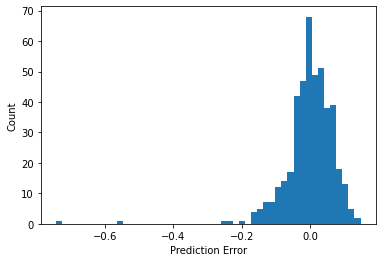

In [20]:
error = pred_lgbm - true_y
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

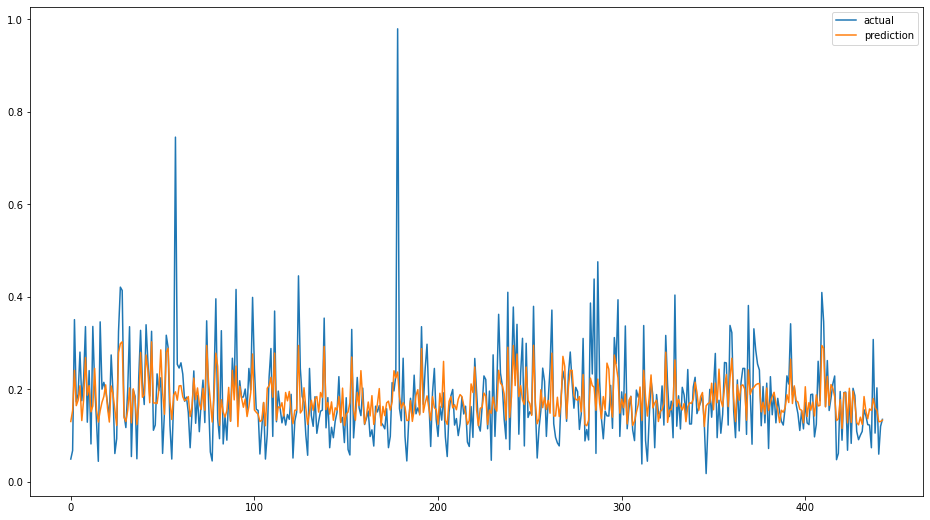

In [21]:
graph(pred_lgbm, true_y)

<AxesSubplot:>

C:\Users\mtang\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\mtang\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44256 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\mtang\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 52628 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\mtang\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\mtang\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\mtang\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47049 missing from c

C:\Users\mtang\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 47000 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\mtang\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\mtang\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 44553 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\mtang\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 55064 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\mtang\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 48156 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\mtang\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 50976 missing from current fon

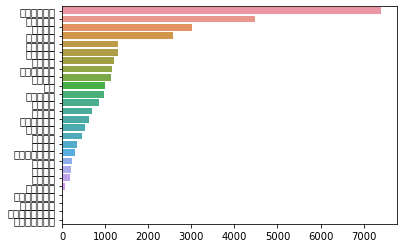

In [24]:
# 회귀 트리 Regressor 클래스는 선형 호귀와 다른 처리 방식이므로 회귀 계수를 제공하는 coef_ 속성이 없다. 
# 대신 feature_importances_를 이요해 피처별 중요도를 알 수 있다. 

feature_series = pd.Series(data=model_lgbm.feature_importances_, index=train_X.columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series, y=feature_series.index)